# Tarea 2 parte 2:  Exoplanetas Transitantes con Kepler

1 
   Del transito se puede obtener directamente el periodo, $\Delta F$, $t_T$ y $t_F$. Estos significan, el cambio de flujo producido por el transito, el tiempo total del transito y el tiempo donde se observa el cambio maximo de flujo.
   
   Otros parametros importantes que se obtienen indirectamente son, $a$:Radio de la orbita, $b$: parametro de impacto, $i$: inclinación del sistema, $M_{\ast}$: Masa estelar ,$R_{\ast}$: Radio estrella , $R_p$: Radio planeta, $M_p$: Masa planeta.
   
   Para despejar estos últimos valores se utilizan tres fórmulas geometricas y dos físicas:
   
   Geométricas:
   
   $\begin{equation} \Delta F=\large(\frac{R_p}{R_{\ast}})^2 \end{equation}$

   $\begin{equation} \frac{tF}{tT}=\large \frac{arcsin(\frac{R_{\ast}}{a} [\frac{(1-\frac{R_p}{R_{\ast}})^2 - (\frac{a}{R_{\ast}cos(i)})^2}{1-cos^2(i)}]^{1/2})}{arcsin(\frac{R_{\ast}}{a} [\frac{(1+\frac{R_p}{R_{\ast}})^2 - (\frac{a}{R_{\ast}cos(i)})^2}{1-cos^2(i)}]^{1/2})} \end{equation}$
   
  
 $\begin{equation} bR_{\ast}=acos(i) \end{equation}$
  
  Físicas:
  
   Tercera ley de Kepler:   $\begin{equation} p^2=\frac{4\pi^2 a^3}{G(M_{\ast}+M_p)} \end{equation}$
   
   Relación radio-masa: $\begin{equation} R_{\ast}=k M^x _{\ast} \end{equation}$ (k y x dependen del tipo de estrella)
   
   
   Con estas ecuaciones se pueden obtener todos los parametros nombrados anteriormente.
   
   Todas estas relaciones se obtienen de Kreidberg et al. 2015.

2.
    Se comienza obteniendo las curvas de luz para KOI-1274.01, se sabe que su periodo es de 702.4 dias.

In [1]:
import kplr


client = kplr.API()
koi = client.koi(1274.01)

/home/zapredfield/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
lcs1 = koi.get_light_curves()

Extraemos los quarters de tiempo,flujo y error de flujo.

In [3]:
teff=[]
logg=[]
feh=[]


time1, flux1, ferr1 = [], [], []
for lc in lcs1:
    with lc.open() as f:  

        hdu_data = f[1].data
        header=f[0].header 
        time1.append(hdu_data["time"]) #obtenemos los tiempos
        flux1.append(hdu_data["pdcsap_flux"]) #flujos
        ferr1.append(hdu_data["pdcsap_flux_err"]) #errores de flujo
teff.append(header["TEFF"]) #cargamos la tempertaura efectiva 
logg.append(header["LOGG"])#cargamos la log(g)
feh.append(header["FEH"]) #cargamos la metalicidad

También se pueden obtener los tres parametros estelares:

In [4]:
print "Temperatura efectiva:",teff[0] ,"log(g):",logg[0],"Metalicidad [Fe/H]:",feh[0]

Temperatura efectiva: 5286 log(g): 4.568 Metalicidad [Fe/H]: -0.26


In [5]:
#Para estrella 1
import matplotlib.pyplot as plt
import numpy


def nan(t,f,err):  #Eliminar NANS
    tf=[]
    ff=[]
    errf=[]
    for i in range(0,len(f)):
        if numpy.isnan(f[i])==False:
            tf.append(t[i])
            ff.append(f[i])
            errf.append(err[i])
    return tf,ff,errf


def unirt(listas): #Función simple para unir listas
    final=[]
    for lista in listas:
        for dato in lista:
            final.append(dato)
    return final




def restarmedia(fs):
    f1=fs[0]
    conc=fs[0]
    anterior=np.nanmean(f1)
    for i in range(1,len(fs)):
        ft=[]
        actual=np.nanmean(fs[i])
        dif=actual-anterior
        for dato in fs[i]:
            dato=dato-dif
            ft.append(dato)
        
        conc=np.concatenate((conc,ft))
        anterior=np.nanmean(conc)
    
    return conc



def unirf(listas): #Función que resta las medias de cada quarter y une listas
    f=[]
    for lista in listas:
        mean=numpy.mean(lista)
        for dato in lista:
            f.append(dato-mean)
    return f


In [6]:
#Primer objeto
#Primero se remueven NANs
import numpy as np
tsinnan=[]
fsinnan=[]
errsinnan=[]
for i in range(0,len(time1)):
    ttemp,ftemp,ferrtemp=nan(time1[i],flux1[i],ferr1[i])
    errsinnan.append(ferrtemp)
    tsinnan.append(ttemp)
    fsinnan.append(ftemp)   

t1=unirt(tsinnan) #Unimos quarters de tiempo
f1=np.array(restarmedia(fsinnan)) #unimos flujos normalizando
ferr1=unirt(errsinnan) #unimos quarters de error del flujo 
forigin=f1

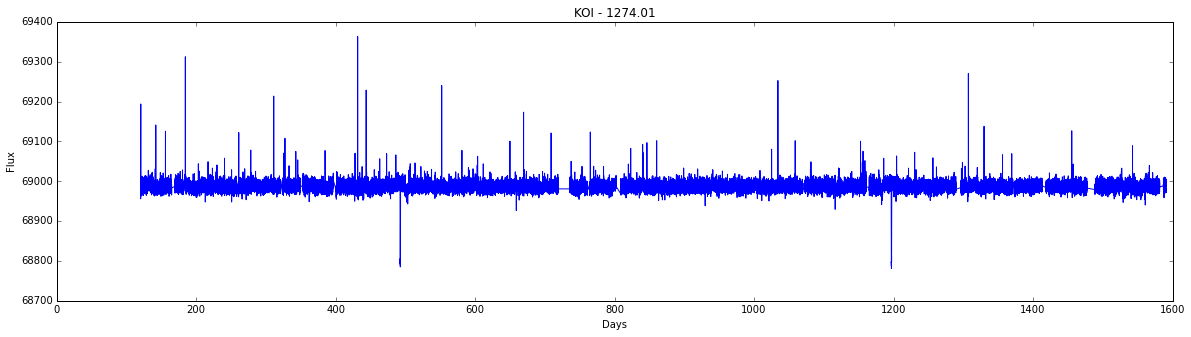

In [7]:
import matplotlib.pyplot as plt
#Funciones de ploteo
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
plt.title("KOI - 1274.01")
plt.xlabel("Days")
plt.ylabel("Flux")
plt.plot(t1,f1,'b')
plt.show()


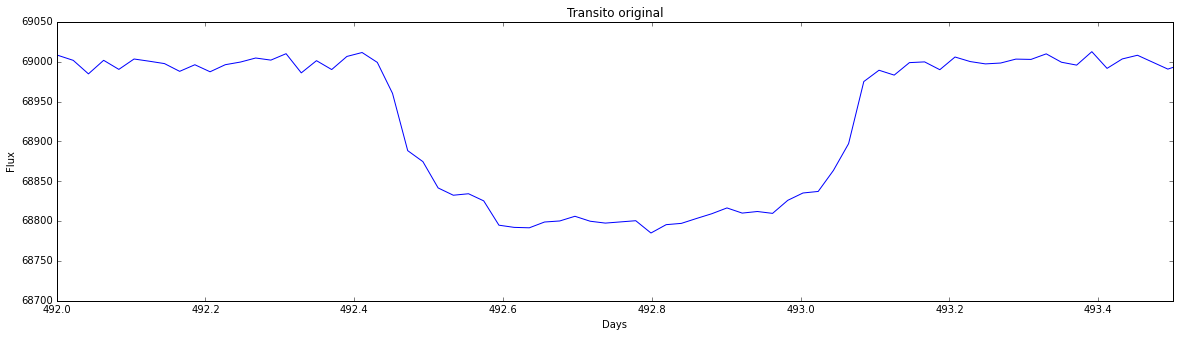

In [8]:
plt.title("Transito original")
plt.plot(t1,f1,'b')
plt.rcParams['figure.figsize'] = (5, 5)
plt.xlim(492,493.5)
plt.ylim(68700,69050)
plt.ylabel("Flux")
plt.xlabel("Days")
plt.show()

El siguiente paso será hacer un proceso de "median filter", en resumen lo que hace esta función es obtener la mediana para cada punto usando los puntos vecinos a este.

In [9]:
#aplicando median filter
import scipy.signal as MF

f1filt=MF.medfilt(f1,501)#Lista de medianas


Esta nueva lista de medianas se utiliza para normalizar la curva de luz original y al mismo tiempo se deben normalizar los errores.

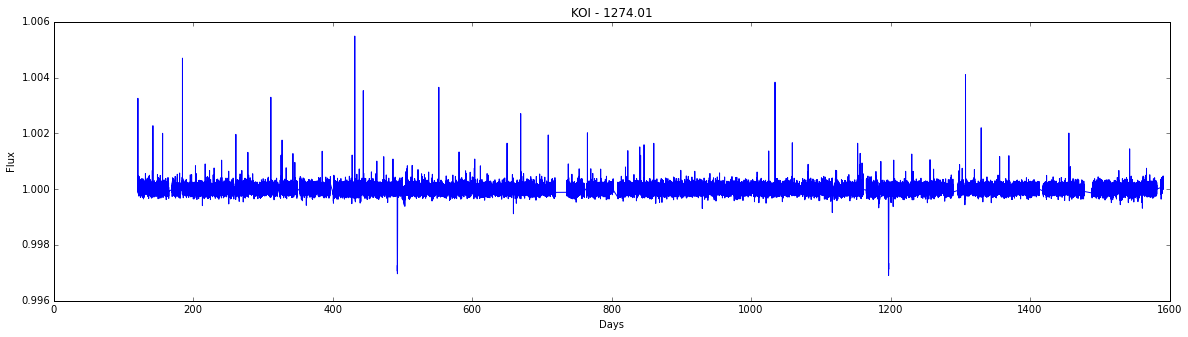

In [10]:
fnorm=f1/f1filt
errnorm=ferr1/f1filt
plt.rcParams['figure.figsize'] = (20, 5)
plt.title("KOI - 1274.01")
plt.plot(t1,fnorm,'b')
plt.xlabel("Days")
plt.ylabel("Flux")
plt.show()


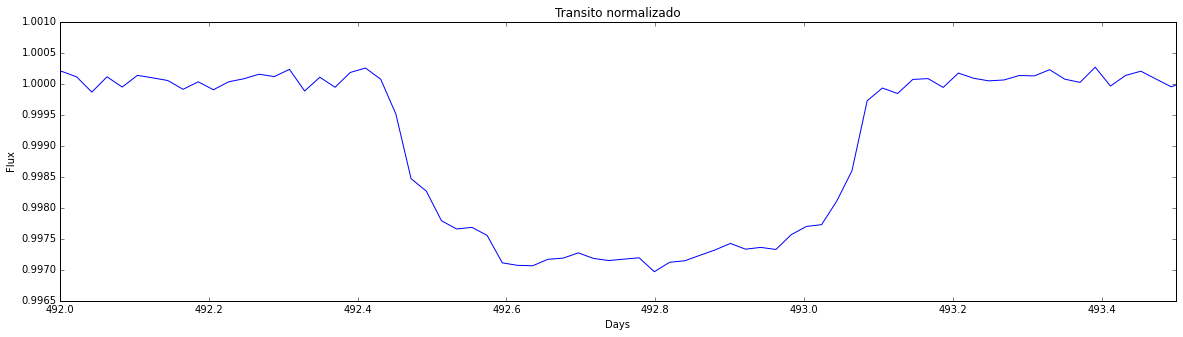

In [11]:
plt.title("Transito normalizado")
plt.plot(t1,fnorm,'b')
plt.rcParams['figure.figsize'] = (2, 2)
plt.xlim(492,493.5)
plt.ylim(0.9965,1.001)
plt.xlabel("Days")
plt.ylabel("Flux")
plt.show()

Luego podemos aplicar un nuevo median filter a la curva normalizada para eliminar las fuertes fluctuaciones que no debiesen estar en el continuo del flujo.

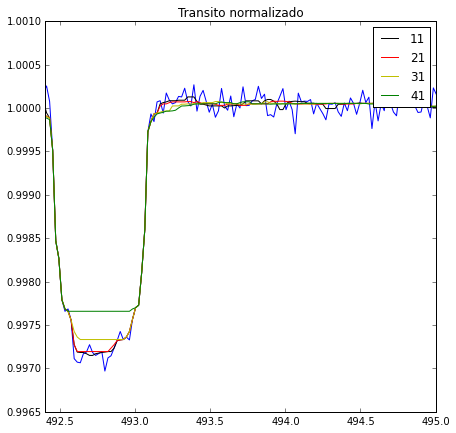

In [12]:
f1=MF.medfilt(fnorm,11)
f2=MF.medfilt(fnorm,21)
f3=MF.medfilt(fnorm,31)
f4=MF.medfilt(fnorm,41)
plt.rcParams['figure.figsize'] = (7,7)
plt.title("Transito normalizado")
plt.plot(t1,fnorm,"b")
plt.plot(t1,f1,'k',label="11")
plt.plot(t1,f2,'r',label="21")
plt.plot(t1,f3,'y',label="31")
plt.plot(t1,f4,'g',label="41")
plt.legend()
plt.xlim(492.4,495)
plt.ylim(0.9965,1.001)
plt.show()

Como se puede ver, para más de 21 vecinos se comienza a perder el transito y entre 11 y 21 no hay gran diferencia, por lo que se filtrara con 11 vecinos.

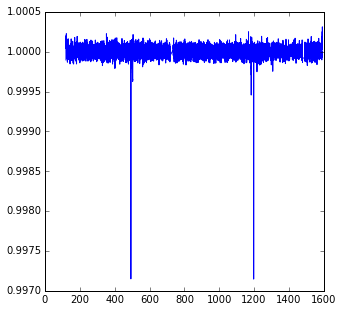

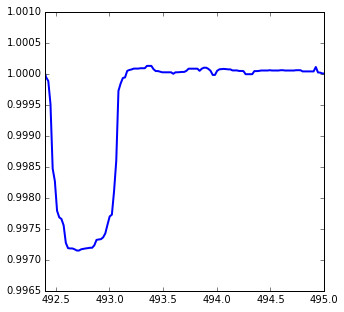

In [13]:
#11 es el mejor punto medio:

f=MF.medfilt(fnorm,11)
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(t1,f,'b')
plt.show()

plt.plot(t1,f,'b',linewidth=2)
plt.rcParams['figure.figsize'] = (5, 5)
plt.xlim(492.4,495)
plt.ylim(0.9965,1.001)
plt.show()

Se elimino una gran cantidad de errores y se mantiene la forma de los transitos.

Si a esto se le agregan las barras de error:

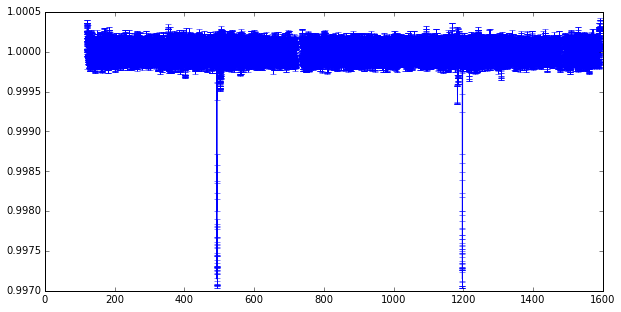

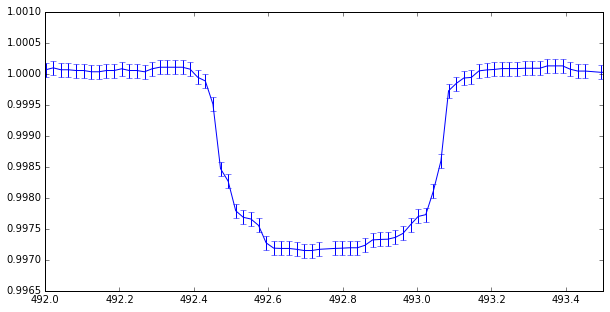

In [14]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.errorbar(t1,f,yerr=errnorm)
plt.show()

plt.errorbar(t1,f,yerr=errnorm)
plt.rcParams['figure.figsize'] = (10, 5)
plt.xlim(492,493.5)
plt.ylim(0.9965,1.001)
plt.show()

El siguiente paso es fasear la curva de luz, ya que tenemos el periodo de 704.2 dias es facil proseguir como en la última tarea:

In [15]:
import numpy as np
from gatspy.periodic import LombScargleFast
def flujovsfase(t,f,ferr,p,name):
    fase = (t/p) % 4
    model = LombScargleFast().fit(t,f,ferr)
    x = np.linspace(0, 4, 100)
    y = model.predict(p*x, period=p)
    plt.rcParams['figure.figsize'] = (20, 10)
    fig, ax = plt.subplots()
    plt.title(name)
    plt.xlim(0,2.4)
    plt.ylim(0.9997,1.0003)

    ax.errorbar(fase, f, ferr, fmt='.k', ecolor='gray', alpha=0.2)
    ax.set(xlabel='Phase', ylabel='Flujo')
    ax.invert_yaxis();
    ax.plot(x, y, lw=3)

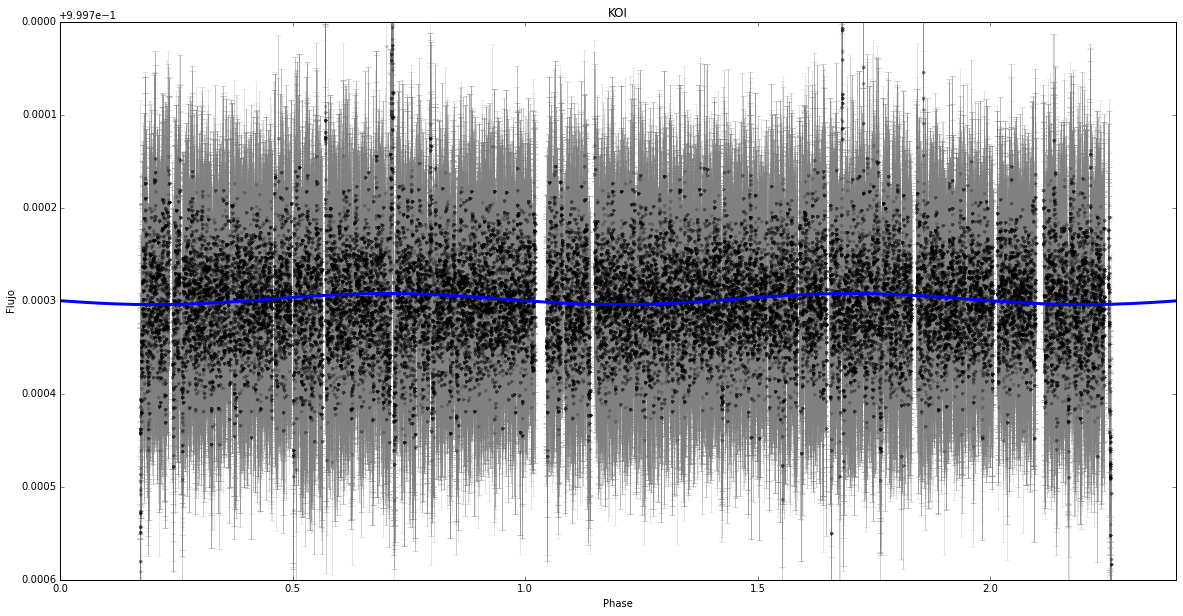

In [16]:
flujovsfase(np.array(t1),f,errnorm,704.2,"KOI")

3.
    En el comirnzo nombramos los parametros que se pueden extraer directamente, tenemos el periodo de 704.2 dias el cual se obtiene al ver la separación temporal de ambos transitos. Para obtener el $\Delta F$ se debe encontrar la diferencia entre el flujo normal y el flujo cuando se da el transito "maximo". Debido a que no tiene una forma de caja perfecta, para obtener $\Delta F$ se tomaran ambos transitos, todos sus puntos de minimo flujo y se promediaran.
    
Es más practico utilizar el flujo sin normalizar para obtener este valor, aunque de todos modos le aplicaremos un filtro de medianas para suavizar errores.
   

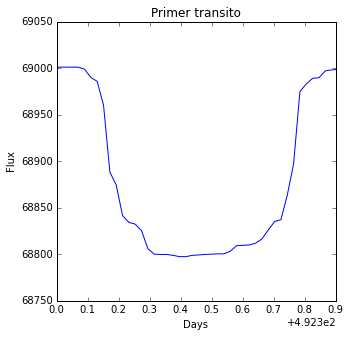

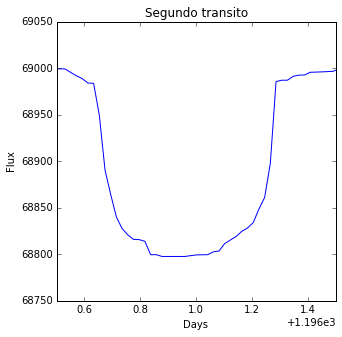

In [17]:
import matplotlib.pyplot as plt
import scipy.signal as MF
forigin=MF.medfilt(forigin,11)
plt.rcParams['figure.figsize'] = (5, 5)
plt.title("Primer transito")
plt.xlabel("Days")
plt.ylabel("Flux")
plt.xlim(492.3,493.2)
plt.plot(t1,forigin)
plt.show()
plt.title("Segundo transito")
plt.xlabel("Days")
plt.ylabel("Flux")
plt.xlim(1196.5,1197.5)
plt.plot(t1,forigin)
plt.show()

Analizando de cerca, para ambos transitos el flujo en su minimo esta en un rango entre 68796 - 68805.

In [18]:
minimos=[]
for i in f:
    if i <=0.9975:
        minimos.append(i)
meantransit=np.mean(minimos)

Para obtener el flujo sin transito buscaremos la mediana de toda la curva de luz, de este modo los pocos datos del transito no serán influyentes.

In [19]:
medianflux=np.median(f)

delta=medianflux-meantransit
print "El delta de flujo es:",delta

El delta de flujo es: 0.00275431951419


Para obtener los tiempos será más simple,el tiempo total se tomará apenas empieze a caer el flujo, el otro se tomará en los mismos puntos considerados para obtener el $\Delta F$:

Estudiando ambos transitos de manera más detallada se ve que en el primero $t_t =0.78$ y $t_f=0.288$, para el segundo $t_t =0.72$ y $t_f=0.27$. Entonces para ser un poco más precisos sacamos una media :

$t_t=0.75$

$t_f=0.279$

4.
    Para utilizar Batman necesitamos varios parámetros iniciales, estos se pueden obtener indirectamente de los observables del transito, la idea será variar $\Delta F$, $t_t$ y $t_f$ alrededor de los valores encontrados por tanteo en la parte 3, luego estos se usaran para obtener los demás parametros desconocidos de batman, por último se encontrara el mejor fit por minimos cuadrados.

In [20]:
#Valores iniciales
import math as mt
rDf=mt.sqrt(0.00275431951419)
tf=0.279
tt=0.75
P=704.2
pi=mt.pi
print rDf

0.0524816112004


Batman debe recibir: 

t0 : El punto medio del transito (dias)

per: periodo (dias)

rp: radio planetario (radios estelares)

a: largo de la orbita (radios estelares)

inc: inclinación de la orbita (Es el $i$ de las ecuaciones de arriba)

ecc: excentricidad (0 ya que asumimos orbita circular)


De las ecuaciones primero despejamos $b$:

In [21]:
def be(rDf,tf,tt,P):
    pi=mt.pi
    
    sin1=(mt.sin(tf*pi/P))**2
    sin2=(mt.sin(tt*pi/P))**2
    
    x=((1-rDf)**2 -(sin1/sin2)*(1+rDf)**2)
    y=1-(sin1/sin2)
    b=(x/y)**0.5
    return b


def apartR(rDf,b,tt,P):
    pi=mt.pi
    temp2=(1+rDf)**2
    temp3=np.sin((tt*np.pi)/P)**2
    aR=((temp2-b**2*temp3)/temp3)**0.5 #Cortesia de matias bravo (Por alguna razon nunca pude escribir la ecuacion correctamente y ya me estaba volviendo loco)
    return aR


def dens(aR,P):
    x=((365.25)**2)/(215**3)
    y=1/(P**2)
    z=aR**3
    rho=x*y*z
    return rho

def inclinacion(b,aR):
    i=np.arccos(b*(1/(aR)))
    return i*(180/np.pi)

b=be(rDf,tf,tt,P)
aR=apartR(rDf,b,tt,P)
rho=dens(aR,P)
i=inclinacion(b,aR)
print "parametro de impacto:",b
print "razón largo de orbita radio estelar:",aR
print "Rp/Rs:",rDf
print "densidad estelar:",rho
print "inclinacion:",i

parametro de impacto: 0.929556195454
razón largo de orbita radio estelar: 314.556247545
Rp/Rs: 0.0524816112004
densidad estelar: 0.842496245155
inclinacion: 89.8306829867


Ahora, enteguemos estos valores a batman para ver que encontramos en un principio:

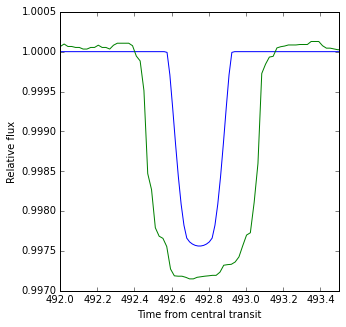

In [22]:
import batman

def spiderman(rDf,aR,i,c1,c2):
    params = batman.TransitParams()
    params.t0 = 492.75                       #time of inferior conjunction
    params.per = 704.2                      #orbital period
    params.rp = rDf                     #planet radius (in units of stellar radii)
    params.a = aR                       #semi-major axis (in units of stellar radii)
    params.inc = i                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [c1, c2]                #limb darkening coefficients
    params.limb_dark = "quadratic"       #limb darkening model
    
    t = np.linspace(492, 493.5, 100)
    
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
    
    plt.plot(t, flux)
    plt.xlabel("Time from central transit")
    plt.ylabel("Relative flux")
    
    
c1=0.1
c2=0.3
spiderman(rDf,aR,i,c1,c2)
plt.rcParams['figure.figsize'] = (7,7)
plt.plot(t1,f)
plt.rcParams['figure.figsize'] = (7,7)
plt.xlim(492,493.5)
plt.show()

Por falta de tiempo obtuve los coeficientes de Limb Darkening con un compañero, usare estos para llevar a cabo el ajuste del transito: 

c1=0.4039

c2=0.27873

Enotnces, para el ajuste utilizaremos scipy.optimize.least_squares para minimizar el indice chi2 entre nuestros puntos reales y el modelo de batman:


Variamos el punto medio del transito, el radio planetario, longitud e inclinacion:

In [23]:
import scipy as sc
t=[] #Tiempos donde hay transito
for i in t1:
    if i<=493.3 and i>=492.2:
        t.append(i)
posiciones=[]
for i in range(0,len(t1)):
    for j in t:
        if t1[i]==j:
            posiciones.append(i)
faj=[]
for i in posiciones:
    faj.append(f[i])

inter=sc.interpolate.interp1d(t,faj)
t = np.linspace(492.2063069079959, 493.28932680340222, 100)
flux=[]

for i in t:
    flux.append(inter(i))
    


La idea entonces es usar la función least squares de python para encontrar el menor indice de chi cuadrado, para esto se hace el cuadrado de la diferencia entre el flujo original de la curva de luz y el del transito modelado por batman.

In [24]:
import scipy as sc

def aquaman(x):
    params = batman.TransitParams()
    params.t0 = x[0]                      #time of inferior conjunction
    params.per = 704.2                      #orbital period
    params.rp = x[1]                     #planet radius (in units of stellar radii)
    params.a = x[2]                       #semi-major axis (in units of stellar radii)
    params.inc = x[3]                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.4039, 0.27873]                #limb darkening coefficients
    params.limb_dark = "quadratic"       #limb darkening model
    
    t = np.linspace(492.2063069079959, 493.28932680340222, 100)
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve

    return flux
    




def minimizar(x):
    dif=0
    bat=np.array(aquaman(x))
    chi2=(flux-bat)**2
    return chi2

x=np.array([492.75,rDf,aR,i])
ayy=sc.optimize.leastsq(minimizar,x)
print ayy[0]

[  4.92750000e+02   5.24816112e-02   3.14556248e+02   4.93289327e+02]


Estos valores anteriores debiesen ser los parametros optimos. Son: t0,rp,a,i

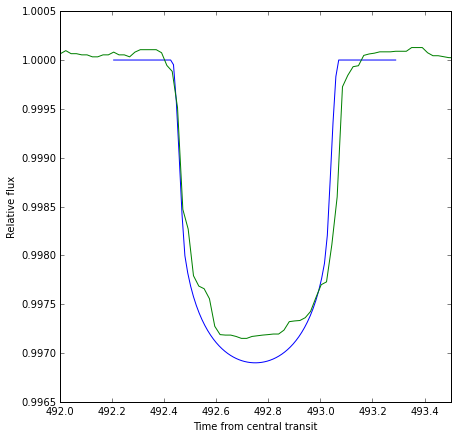

In [25]:

params = batman.TransitParams()
params.t0 = 492.750000                     #time of inferior conjunction
params.per = 704.2                      #orbital period
params.rp = 0.0524816112                      #planet radius (in units of stellar radii)
params.a = 314.556248                       #semi-major axis (in units of stellar radii)
params.inc = 89.898                    #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.4039, 0.27873]                #limb darkening coefficients
params.limb_dark = "quadratic"       #limb darkening model

t = np.linspace(492.2063069079959, 493.28932680340222, 100)

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve

plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")


plt.rcParams['figure.figsize'] = (7,7)
plt.plot(t1,f)
plt.rcParams['figure.figsize'] = (7,7)
plt.xlim(492,493.5)
plt.show()

A pesar de que el ajuste no funcionó a la perfección debido a que el ángulo no dio un valor dentro de lo normal. Dandole un i=89.898  se encuentra un fit más decente que el que teniamos en un principio.